In [1]:
import numpy as np
import matplotlib.pyplot as plt
import util
import tensorflow as tf

from sklearn.utils import shuffle

from util import getImageData, error_rate, init_weight_and_bias, y2indicator

C:\Users\Denis\AppData\Local\conda\conda\envs\tensorflow_env_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    return w.astype(np.float32)


class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2,2)):
        sz = (fw, fh, mi, mo)
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]
        
    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        return tf.tanh(pool_out)

class CNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, lr=10e-4, mu=0.99, reg=10e-4, decay=0.99999, eps=10e-3, batch_sz=30, epochs=3, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))
        
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)
        
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1)
        
        N, d, d, c = X.shape
        mi = c
        outw = d
        outh = d
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            outw = outw / 2
            outh = outh / 2
            mi = mo
        
        self.hidden_layers = []
        M1 = int(self.convpool_layer_sizes[-1][0]*outw*outh)
        count = 0
        for M2 in self.hidden_layer_sizes:
            print(M1, M2)
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_log')
        
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params
            
        tfX = tf.placeholder(tf.float32, shape=(None, d, d, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)
        
        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act, labels=tfY)) + rcost
        prediction = self.predict(tfX)
        
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        
        n_batches = N // batch_sz
        costs = []
        init = tf.initialize_all_variables()
        
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]
                    
                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})
                    
                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)
                        
                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error_rate:", e)
                        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b
    
    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)

2880 500
500 300
Instructions for updating:
Use `tf.global_variables_initializer` instead.
i: 0 j: 0 nb: 1308 cost: 2.2717009 error_rate: 0.856
i: 0 j: 20 nb: 1308 cost: 2.2482107 error_rate: 0.776
i: 0 j: 40 nb: 1308 cost: 2.2476878 error_rate: 0.776
i: 0 j: 60 nb: 1308 cost: 2.2568274 error_rate: 0.84
i: 0 j: 80 nb: 1308 cost: 2.246126 error_rate: 0.777
i: 0 j: 100 nb: 1308 cost: 2.238342 error_rate: 0.776
i: 0 j: 120 nb: 1308 cost: 2.2290041 error_rate: 0.776
i: 0 j: 140 nb: 1308 cost: 2.2198272 error_rate: 0.776
i: 0 j: 160 nb: 1308 cost: 2.213731 error_rate: 0.776
i: 0 j: 180 nb: 1308 cost: 2.204628 error_rate: 0.776
i: 0 j: 200 nb: 1308 cost: 2.1923547 error_rate: 0.775
i: 0 j: 220 nb: 1308 cost: 2.2114177 error_rate: 0.802
i: 0 j: 240 nb: 1308 cost: 2.1962833 error_rate: 0.734
i: 0 j: 260 nb: 1308 cost: 2.166882 error_rate: 0.757
i: 0 j: 280 nb: 1308 cost: 2.1444333 error_rate: 0.745
i: 0 j: 300 nb: 1308 cost: 2.1439178 error_rate: 0.688
i: 0 j: 320 nb: 1308 cost: 2.113922 error

i: 2 j: 240 nb: 1308 cost: 1.470299 error_rate: 0.459
i: 2 j: 260 nb: 1308 cost: 1.4633791 error_rate: 0.456
i: 2 j: 280 nb: 1308 cost: 1.4278784 error_rate: 0.444
i: 2 j: 300 nb: 1308 cost: 1.4321721 error_rate: 0.453
i: 2 j: 320 nb: 1308 cost: 1.4241188 error_rate: 0.442
i: 2 j: 340 nb: 1308 cost: 1.4143592 error_rate: 0.439
i: 2 j: 360 nb: 1308 cost: 1.4145253 error_rate: 0.432
i: 2 j: 380 nb: 1308 cost: 1.4402261 error_rate: 0.442
i: 2 j: 400 nb: 1308 cost: 1.4477124 error_rate: 0.451
i: 2 j: 420 nb: 1308 cost: 1.4418405 error_rate: 0.441
i: 2 j: 440 nb: 1308 cost: 1.4432935 error_rate: 0.431
i: 2 j: 460 nb: 1308 cost: 1.4405432 error_rate: 0.442
i: 2 j: 480 nb: 1308 cost: 1.4358933 error_rate: 0.449
i: 2 j: 500 nb: 1308 cost: 1.4425517 error_rate: 0.441
i: 2 j: 520 nb: 1308 cost: 1.4874531 error_rate: 0.472
i: 2 j: 540 nb: 1308 cost: 1.4558039 error_rate: 0.444
i: 2 j: 560 nb: 1308 cost: 1.4448749 error_rate: 0.447
i: 2 j: 580 nb: 1308 cost: 1.4201701 error_rate: 0.447
i: 2 j: 600

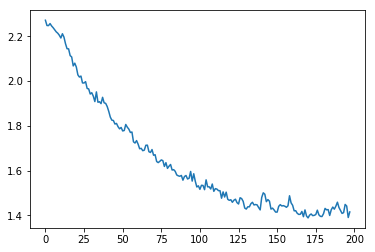

In [3]:
X, Y = getImageData()

X = X.transpose((0, 2, 3, 1))

model = CNN(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
model.fit(X, Y, show_fig=True)